In [97]:
# This program approximately predicts the given food image and shows its nutritional datas
# Uses machine learning and Convolutional Neural Networks(CNN) by using Tensorflow and Keras backend

In [120]:
# Importing required libraries

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras.applications.inception_v3 import InceptionV3
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.optimizers import SGD
from keras.regularizers import l2
from keras import layers
from keras.utils import to_categorical
plt.style.use('fivethirtyeight')

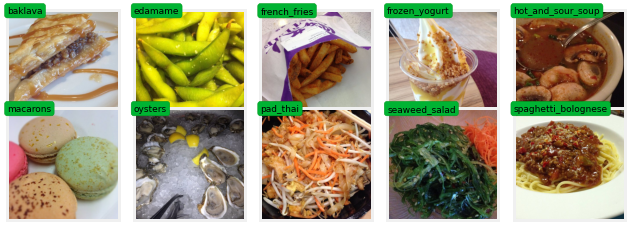

In [99]:
# Showing some images from data directions

train_dir = "C:/Users/LENOVO/Desktop/ai-project/split/train"
test_dir = "C:/Users/LENOVO/Desktop/ai-project/split/test"
foods = ["baklava", "edamame", "french_fries", "frozen_yogurt", "hot_and_sour_soup",
         "macarons", "oysters", "pad_thai", "seaweed_salad", "spaghetti_bolognese"]

fig, ax = plt.subplots(2, 5, frameon=False, figsize=(9, 15))
sorted_food_dirs = sorted(os.listdir(train_dir))
for i in range(2):
    for j in range(5):
        try:
            food_dir = sorted_food_dirs[i*5 + j]
        except:
            break
        all_files = os.listdir(os.path.join(train_dir, food_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(train_dir, food_dir, rand_img))
        ax[i][j].imshow(img)
        ec = (0, .6, .1)
        fc = (0, .7, .2)
        ax[i][j].text(0, -20, food_dir, size=9, rotation=0,
                ha="left", va="top", 
                bbox=dict(boxstyle="round", ec=ec, fc=fc))
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.5])

In [67]:
# Getting the train and test datas and printing the shapes of train and test images

for category in foods:
    path = os.path.join(train_dir, category)
    for img in os.listdir(path):
        train_img_array = cv2.imread(os.path.join(path, img))
    path = os.path.join(test_dir, category)
    for img in os.listdir(path):
        test_img_array = cv2.imread(os.path.join(path, img))

print(train_img_array.shape)
print(test_img_array.shape)

(512, 512, 3)
(510, 512, 3)


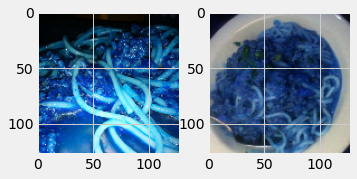

In [69]:
# Showing train and test image examples that are resized 

IMG_SIZE = 128

fig=plt.figure(figsize=(5, 5))

train_new_array = cv2.resize(train_img_array, (IMG_SIZE, IMG_SIZE))
fig.add_subplot(1, 2, 1)
plt.imshow(train_new_array)
test_new_array = cv2.resize(test_img_array, (IMG_SIZE, IMG_SIZE))
fig.add_subplot(1, 2, 2)
plt.imshow(test_new_array)
plt.show()

In [6]:
# Defining training and testing data arrays and 
# storing their images and categories as labels inside of the arrays.

training_data = []
testing_data = []

def create_training_data():
    for category in foods:
        path = os.path.join(train_dir, category)
        class_num = foods.index(category)
        for img in os.listdir(path):
            try:
                train_img_array = cv2.imread(os.path.join(path, img))
                train_new_array = cv2.resize(train_img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([train_new_array, class_num])
            except Exception as e:
                pass

def create_testing_data():
    for category in foods:
        path = os.path.join(test_dir, category)
        class_num = foods.index(category)
        for img in os.listdir(path):
            try:
                test_img_array = cv2.imread(os.path.join(path, img))
                test_new_array = cv2.resize(test_img_array, (IMG_SIZE, IMG_SIZE))
                testing_data.append([test_new_array, class_num])
            except Exception as e:
                pass

create_training_data()
create_testing_data()

In [7]:
print("Training data length: ", len(training_data))
print("Testing data length: ", len(testing_data))

Training data length:  7000
Testing data length:  3000


In [70]:
# Shuffling training and testing data to prevent overfitting

import random

random.shuffle(training_data)
random.shuffle(testing_data)

In [9]:
x_train = []
y_train = []
x_test = []
y_test = []

In [10]:
for features, label in training_data:
    x_train.append(features)
    y_train.append(label)

for features, label in testing_data:
    x_test.append(features)
    y_test.append(label)

x_train = np.array(x_train).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y_train = np.array(y_train)
x_test = np.array(x_test).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y_test = np.array(y_test)

In [11]:
# normalizing images and casting labels to be categorical

x_train = x_train/255.0
x_test = x_test/255.0
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [12]:
# Generating new images from existing training datas
# to increase the number of trainable datas

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(128, 128),
        batch_size=16,
        class_mode='categorical')

Found 7000 images belonging to 10 classes.


In [13]:
## Also generating new images for testing datas

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(128, 128),
        batch_size=16,
        class_mode='categorical')

Found 3000 images belonging to 10 classes.


In [14]:
## Designing a sequential training model and showing first and last epoch values

inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(10,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_son.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history2.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = 7000 // 16,
                    validation_data=test_generator,
                    validation_steps= 3000 // 16,
                    epochs=10,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained2.hdf5')

Epoch 1/10
437/437 [==============================] - 1093s 3s/step - loss: 2.1867 - accuracy: 0.2669 - val_loss: 1.8570 - val_accuracy: 0.4893

Epoch 00001: val_loss improved from inf to 1.85699, saving model to best_model2.hdf5
Epoch 2/10
437/437 [==============================] - 890s 2s/step - loss: 1.4440 - accuracy: 0.5803 - val_loss: 1.0300 - val_accuracy: 0.6947

Epoch 00002: val_loss improved from 1.85699 to 1.03000, saving model to best_model2.hdf5
Epoch 3/10
437/437 [==============================] - 832s 2s/step - loss: 1.0585 - accuracy: 0.6963 - val_loss: 1.1303 - val_accuracy: 0.7678

Epoch 00003: val_loss did not improve from 1.03000
Epoch 4/10
437/437 [==============================] - 830s 2s/step - loss: 0.8544 - accuracy: 0.7617 - val_loss: 0.7883 - val_accuracy: 0.7986

Epoch 00004: val_loss improved from 1.03000 to 0.78828, saving model to best_model2.hdf5
Epoch 5/10
437/437 [==============================] - 850s 2s/step - loss: 0.7785 - accuracy: 0.7847 - val_lo

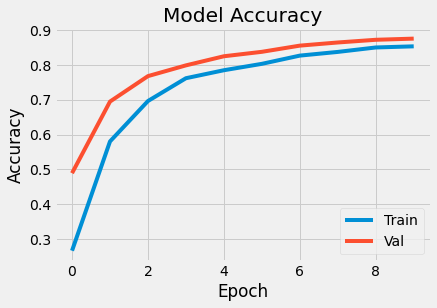

In [84]:
## Showing the plot of the accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Val'], loc = 'best')
plt.show()

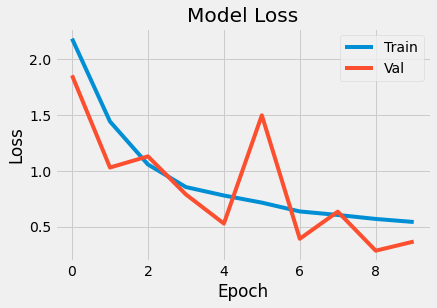

In [16]:
## Showing the plot of the loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Val'], loc = 'best')
plt.show()

In [155]:
## Predicting the name of the randomly selected images of all foods

from keras.preprocessing import image
from skimage.transform import resize
from keras.models import load_model
model_best = load_model('best_model2.hdf5',compile = False)

images = ['baklava.jpg', 'edamame.jpg', 'french_fries.jpg', 'frozen_yogurt.jpg', 'hot_and_sour_soup.jpg', 
          'macarons.jpg', 'oysters.jpg', 'pad_thai.jpg', 'seaweed_salad.jpg', 'spaghetti_bolognese.jpg']
test_food_dir = 'C:/Users/LENOVO/Desktop/ai-project/test-photos'
predicted_images = []
keys = []
per = []

for img in images:
    img = plt.imread(os.path.join(test_food_dir, img))
    img = resize(img, (128,128,3))

    pred = model_best.predict(np.array([img]))
    index = np.argmax(pred)
    foods.sort()
    per.append(round(pred[0][index]*100, 3)) 
    pred_value = foods[index]
    keys.append(pred_value)
    predicted_images.append([img, pred_value])

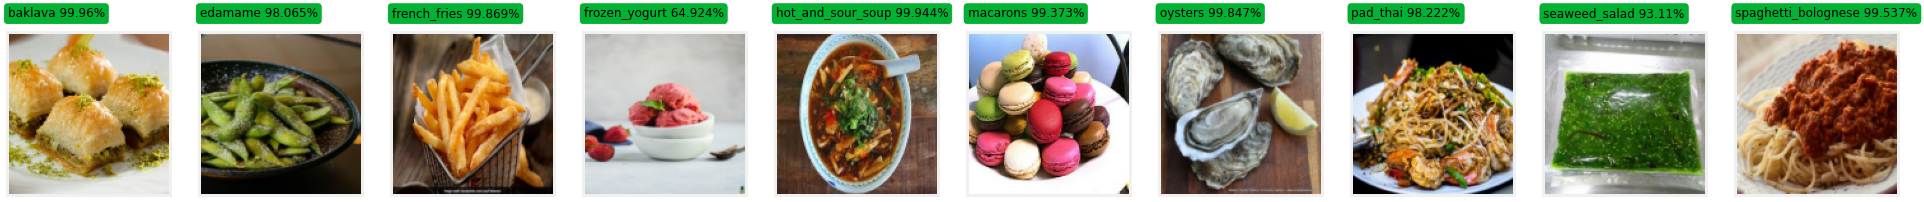

In [160]:
## Showing the images and printing the label and prediction percentages of the foods

fig, ax = plt.subplots(1, 10, frameon=False, squeeze=False, figsize=(30, 30))
for i in range(10):
    ax[0][i].imshow(predicted_images[i][0])
    ec = (0, .6, .1)
    fc = (0, .7, .2)
    text = predicted_images[i][1] + ' ' + str(per[i]) + '%' 
    ax[0][i].text(0, -20, text, size=12, rotation=0,
            ha="left", va="top", 
            bbox=dict(boxstyle="round", ec=ec, fc=fc))
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 0.9, 0.7])

In [161]:
## Getting the nutritional datas of the predicted food
## by reading nutritions.json file 

import json

with open('./nutritions.json') as f:
  data = json.load(f)

for i in range(10):
  print(keys[i])
  print(json.dumps(data[keys[i]], indent=4, sort_keys=True))

baklava
{
    "amount": "1 piece (76g)",
    "calories": "306",
    "calories_from_fat": "178",
    "cholesterol": "21mg",
    "potassium": "146mg",
    "protein": "5.5g",
    "sodium": "213mg",
    "total_carbohydrates": "29g",
    "total_fat": "20g"
}
edamame
{
    "amount": "1 cup (155g)",
    "calories": "188",
    "calories_from_fat": "73",
    "cholesterol": "0mg",
    "potassium": "676mg",
    "protein": "18g",
    "sodium": "9.3mg",
    "total_carbohydrates": "14g",
    "total_fat": "8.1g"
}
french_fries
{
    "amount": "1 serving medium (117g)",
    "calories": "365",
    "calories_from_fat": "155",
    "cholesterol": "0mg",
    "potassium": "677mg",
    "protein": "4g",
    "sodium": "246mg",
    "total_carbohydrates": "48g",
    "total_fat": "17g"
}
frozen_yogurt
{
    "amount": "1 cup (174g)",
    "calories": "221",
    "calories_from_fat": "56",
    "cholesterol": "23mg",
    "potassium": "271mg",
    "protein": "5.2g",
    "sodium": "110mg",
    "total_carbohydrates": "38

In [145]:
import tkinter as tk
from tkinter import filedialog
from tkinter import *
from PIL import ImageTk, Image
import numpy as np

#load the trained model to classify the images
from keras.models import load_model
model = load_model('best_model2.hdf5', compile=False)

food_list = {
    0: 'Baklava',
    1: 'Edamame',
    2: 'French Fries',
    3: 'Frozen Yogurt',
    4: 'Hot and Sour Soup',
    5: 'Macarons',
    6: 'Oysters',
    7: 'Pad Thai',
    8: 'Seaweed Salad',
    9: 'Spaghetti Bolognese' 
}

#initialise GUI
top=tk.Tk()
top.geometry('800x600')
top.title('Food Nutrition Data')
top.configure(background='#CDCDCD')
label=Label(top,background='#CDCDCD', font=('arial',15,'bold'))
sign_image = Label(top)

def classify(file_path):
    global label_packed
    image = plt.imread(file_path)
    image = resize(image, (128, 128, 3))
    pred = model.predict(np.array([image]))
    index = np.argmax(pred)
    sign = food_list[index]
    print(sign)
    label.configure(foreground='#011638', text=sign)

def show_classify_button(file_path):
    classify_b=Button(top,text="Classify Image", 
                          command=lambda: classify(file_path),
                          padx=10,
                          pady=5)
    classify_b.configure(background='#364156', 
                         foreground='white',
                         font=('arial',10,'bold'))
    classify_b.place(relx=0.79,rely=0.46)

def upload_image():
    try:
        file_path=filedialog.askopenfilename()
        uploaded=Image.open(file_path)
        uploaded.thumbnail(((top.winfo_width()/2.25),(top.winfo_height()/2.25)))
        im=ImageTk.PhotoImage(uploaded)
        sign_image.configure(image=im)
        sign_image.image=im
        label.configure(text='')
        show_classify_button(file_path)
    except:
        pass

upload=Button(top,text="Upload an image",
                  command=upload_image,
                  padx=10,
                  pady=5)

upload.configure(background='#364156', 
                 foreground='white',
                 font=('arial',10,'bold'))

upload.pack(side=BOTTOM,pady=50)
sign_image.pack(side=BOTTOM,expand=True)
label.pack(side=BOTTOM,expand=True)
heading = Label(top, text="Food Nutrition Data",pady=20, font=('arial',20,'bold'))


heading.configure(background='#CDCDCD',foreground='#364156')
heading.pack()
top.mainloop()

Baklava
Edamame
Hot and Sour Soup
Pad Thai
Baklava
Edamame
French Fries
Macarons
Oysters
Seaweed Salad
Spaghetti Bolognese
